In [1]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import dask.dataframe as dd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# Theoretic part

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation).
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

Your answer: C

Explanation C: The location peaks represent that the time-series have periodicity. And if the local peaks appears at t=7,14,21,28, it means that the data might have the same trend every seven days.

### Question 2 (Stationarity).

Which of the following time-series models are always stationary:

A. Linear trend

B. MA(1) model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Your answer: B, C, E

Explaination A: The mean value of linear trend always changes because many linear models changes with the time, such as the price model, population model and GDP model. So linear trend is not always stationarity.

Explaination B and E: MA, ARMA produce stationary time-series.

Explaination C: White Noise is stationary because its will change regularly over time.

Explaination D: Random walk process is the time-series (stochastic process) adding a random step at each moment of time. Both the mean and the variance increase over time.

Explaination F: for d > 0, the ARIMA model is capable of prodicingnon-stationary time-series as similar to the random walk processes. So, when d=1, the ARIMA is not always stationary.


### Question 3 (PCA).
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

Your answer: B, D, E

Explaination A:  Leading principal components can explain most part of the variance, but sometimes they can not gain the most efficient information.

Explaination B: Standardization ensures that features have similar scales and variances, thereby reducing correlations due to scale differences.

Explaination C: If we use too much features, there might still exist overfitting problem.

Explaination D: PCA enables us to remove lots of features and keep the uncorrelated features , which will prevent overfitting.

Explaination E: PCA cannot explain the model directly because they are linear combination of original features.

### Question 4 (MapReduce).

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of your CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



Your answer: B, E

Explaination A: MapReduce is a pattern for processing datasets. It doesn't have any specific function, so it is not a module.

Explaination B: The MapReduce divides the goal into many small assignments, which enables us to conduct parallel computing.

Explaination C: It depends. If the task is too easy and just takes one step, use traditional way might be faster.

Explaination D: It depends. If the task is too easy and just takes one step, MapReduce might not be so efficient.

Explaination E: Multiprocessing and PySpark also can compute parallelly. They serve similar functions to MapReduce.

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading.

## 1. Data downloading
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [2]:
# dataDir = 'taxidata'
# if os.path.exists(dataDir):
#     pass
# else:
#     os.mkdir(dataDir)
# Years = [2017,2018]
# Months = range(1,13)
# VehicleTypes = ['yellow']

# def getUrl(cabtype,year,month):
#     baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'

#     month = str(month).zfill(2)
#     fileName = '%s_tripdata_%s-%s.parquet'%(cabtype,year,month)

#     return baseUrl + fileName, fileName

In [3]:
# for year in Years:
#     for month in Months:
#         for cabtype in VehicleTypes:
#             url, fileName = getUrl(cabtype,year,month)

#             print("Downloading: "+str(fileName))

#             if fileName in os.listdir(dataDir):
#                 print("file exists")
#                 continue

#             filePath = os.path.join(dataDir, fileName)
#             try:
#                 urllib.request.urlretrieve(url, filePath)
#             except:
#                 # if fails remove the incomplete file
#                 os.remove(filePath)
#                 try:
#                     # start again after a delay of 2 min
#                     time.sleep(60*2)
#                     urllib.request.urlretrieve(url, filePath)
#                 except:
#                     print("Download this file later!")
#                     pass

## 2. Data Preprocessing
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc.

Hint:
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_parquet("*.parquet") to read all parquet file in a folder
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/taxidata/')
dataDir = '/content/drive/MyDrive/taxidata/'

In [6]:
# Read the Parquet file using Dask

df = dd.read_parquet(os.path.join(dataDir, '*.parquet'),
                     columns=['tpep_pickup_datetime', 'PULocationID', 'DOLocationID', 'passenger_count'],
                     engine='pyarrow')

# Display the first few rows of the DataFrame
df.head()

,tpep_pickup_datetime,PULocationID,DOLocationID,passenger_count
0,2017-01-01 00:32:05,140,236,1
1,2017-01-01 00:43:25,237,140,2
2,2017-01-01 00:49:10,140,237,2
3,2017-01-01 00:36:42,41,42,1
4,2017-01-01 00:07:41,48,263,1


In [7]:
# get the ridership from JFK
df = df[df['PULocationID'] == 132]

df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.date
df['hour'] = df['tpep_pickup_datetime'].dt.hour

result = df.groupby(['date', 'hour', 'DOLocationID'])['passenger_count'].sum().reset_index()
result = result.compute()

taxi = result.pivot_table(index=['date', 'hour'], columns='DOLocationID', values='passenger_count', fill_value=0).reset_index()
taxi.head()

DOLocationID,date,hour,1,2,3,4,5,6,7,8,...,256,257,258,259,260,261,262,263,264,265
0,2002-12-31,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003-01-01,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2003-01-01,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2008-12-31,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008-12-31,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [8]:
complete_time = pd.DataFrame({'datetime': pd.date_range(start='2017-01-01', end='2018-12-31 23:00:00', freq='H')})
complete_time['date'] = complete_time['datetime'].dt.date
complete_time['hour'] = complete_time['datetime'].dt.hour

complete_time['date'] = pd.to_datetime(complete_time['date'])
complete_time = complete_time.drop('datetime', axis=1)
complete_time.head()

,date,hour
0,2017-01-01,0
1,2017-01-01,1
2,2017-01-01,2
3,2017-01-01,3
4,2017-01-01,4


In [9]:
locations = taxi.drop(['date','hour'], axis=1).columns
daily_taxi = taxi.groupby(['date','hour'])[locations].sum().reset_index()
taxi['date'] = pd.to_datetime(taxi['date'])
start_date = "2017-01-01"
end_date = "2018-12-31"
daily_taxi1 = taxi[(taxi['date'] >= start_date) & (taxi['date'] <= end_date)]
daily_taxi1.head()

DOLocationID,date,hour,1,2,3,4,5,6,7,8,...,256,257,258,259,260,261,262,263,264,265
21,2017-01-01,0,0,0,0,1,0,0,2,0,...,0,3,0,0,1,0,3,0,3,27
22,2017-01-01,1,0,0,0,2,0,0,5,0,...,6,0,0,0,0,5,7,6,1,12
23,2017-01-01,2,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,10
24,2017-01-01,3,0,0,0,0,0,0,1,0,...,1,0,2,0,0,0,0,0,0,4
25,2017-01-01,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [10]:
taxi_JFK = pd.merge(complete_time, daily_taxi1, on=['date', 'hour'], how='left').fillna(0)

In [11]:
taxi_JFK_shape = taxi_JFK.shape
print(taxi_JFK_shape)

(17520, 265)


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records.

In [12]:
#your answer here

In [13]:
taxi_JFK1 = dd.from_pandas(taxi_JFK, npartitions=24)
locations = taxi_JFK1.drop(['date','hour'], axis=1).columns
daily_taxi = taxi_JFK1.groupby('date')[locations].sum().reset_index()
daily_taxi['total'] = daily_taxi.drop(columns=['date']).sum(axis=1)
daily_taxi_17_18=daily_taxi.persist()
daily_taxi_2017 = daily_taxi.query('date >= "2017-01-01" and date <= "2017-12-31"').persist()
daily_taxi_pd = daily_taxi.compute()
daily_taxi_pd.head()

,date,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,total
0,2017-01-01,15.0,1.0,0.0,72.0,0.0,4.0,136.0,0.0,27.0,...,55.0,38.0,10.0,36.0,31.0,221.0,212.0,35.0,329.0,14710.0
1,2017-01-02,13.0,0.0,4.0,74.0,0.0,0.0,192.0,0.0,11.0,...,35.0,41.0,8.0,50.0,65.0,227.0,276.0,48.0,315.0,16723.0
2,2017-01-03,26.0,0.0,9.0,47.0,0.0,0.0,171.0,2.0,17.0,...,50.0,45.0,16.0,55.0,66.0,150.0,221.0,54.0,388.0,16072.0
3,2017-01-04,21.0,0.0,3.0,43.0,0.0,5.0,142.0,0.0,3.0,...,36.0,32.0,9.0,12.0,62.0,141.0,150.0,42.0,321.0,14549.0
4,2017-01-05,8.0,1.0,3.0,58.0,0.0,0.0,83.0,0.0,8.0,...,8.0,23.0,4.0,38.0,45.0,77.0,115.0,40.0,305.0,12239.0


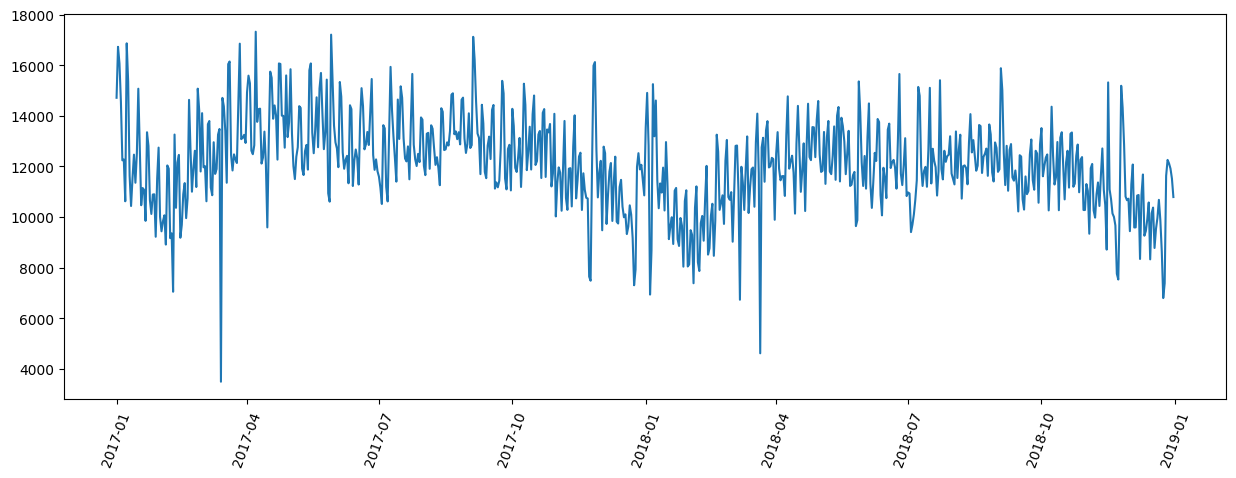

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(daily_taxi_pd.date, daily_taxi_pd.total)
plt.xticks(rotation=70);
plt.show()

### 3.2 Period detection and report the strongest period length on the 2017 data.
Hint: using periodogram or acf plot.

In [15]:
#your answer here


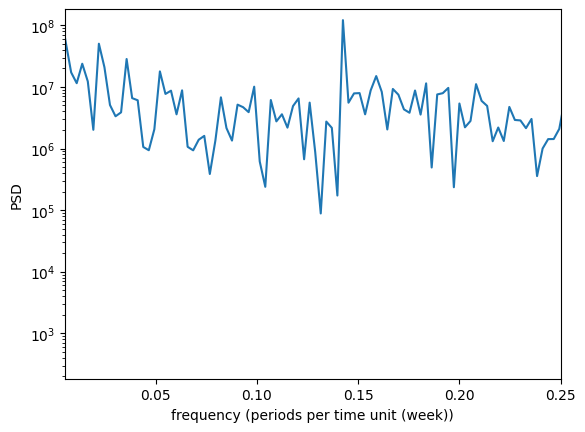

Strongest period length = 7.019230769230769


In [16]:
f, PSD = scipy.signal.periodogram(daily_taxi_2017.total)
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (week))')
plt.ylabel('PSD')
plt.xlim(0.005,0.25) #show frequencies within 1/4..1/200, periods of 4-200 weeks
plt.ylim(max(PSD)/1e6,max(PSD)) #show strength up to 1e-6 of the max

#filter outputs - periods shorter than 2 years (approx 100 weeks)
PSD = PSD[f>0.01]
f = f[f>0.01]
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period

#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

From the result, we can see that the period might be 7 days.

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, .

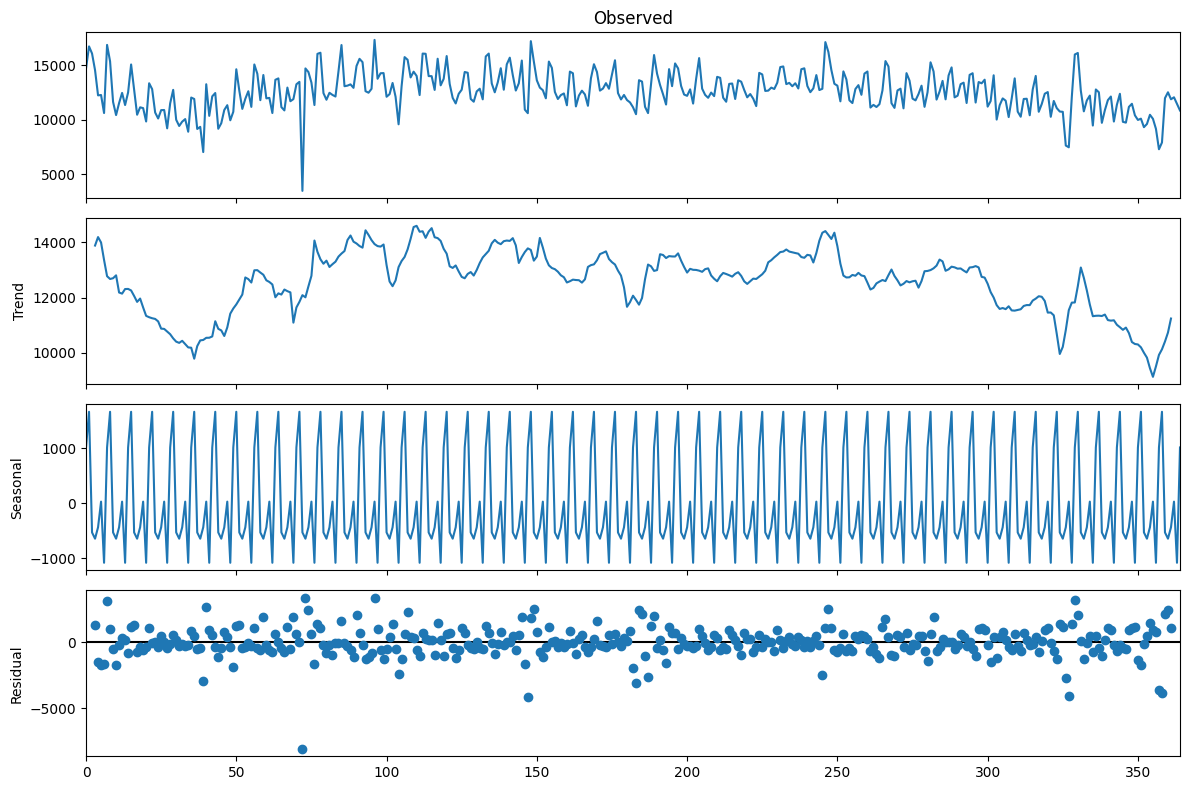

In [17]:
#your answer here
plt.rcParams['figure.figsize'] = [12, 8]

res = sm.tsa.seasonal_decompose(daily_taxi_2017.total, model='additive', period=7)

res.plot()
plt.show()

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05.

First, let's test the stability of the aggregated dataset.

In [18]:
#your answer here
# predict the aggregated daily ridership
series=daily_taxi_pd['total']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.153742
p-value: 0.223460
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


So having a p-value of 22.3\% we can't reject the null hypothesis, the time-series might not be stationary. Therefore, I'm going to apply differencing method.

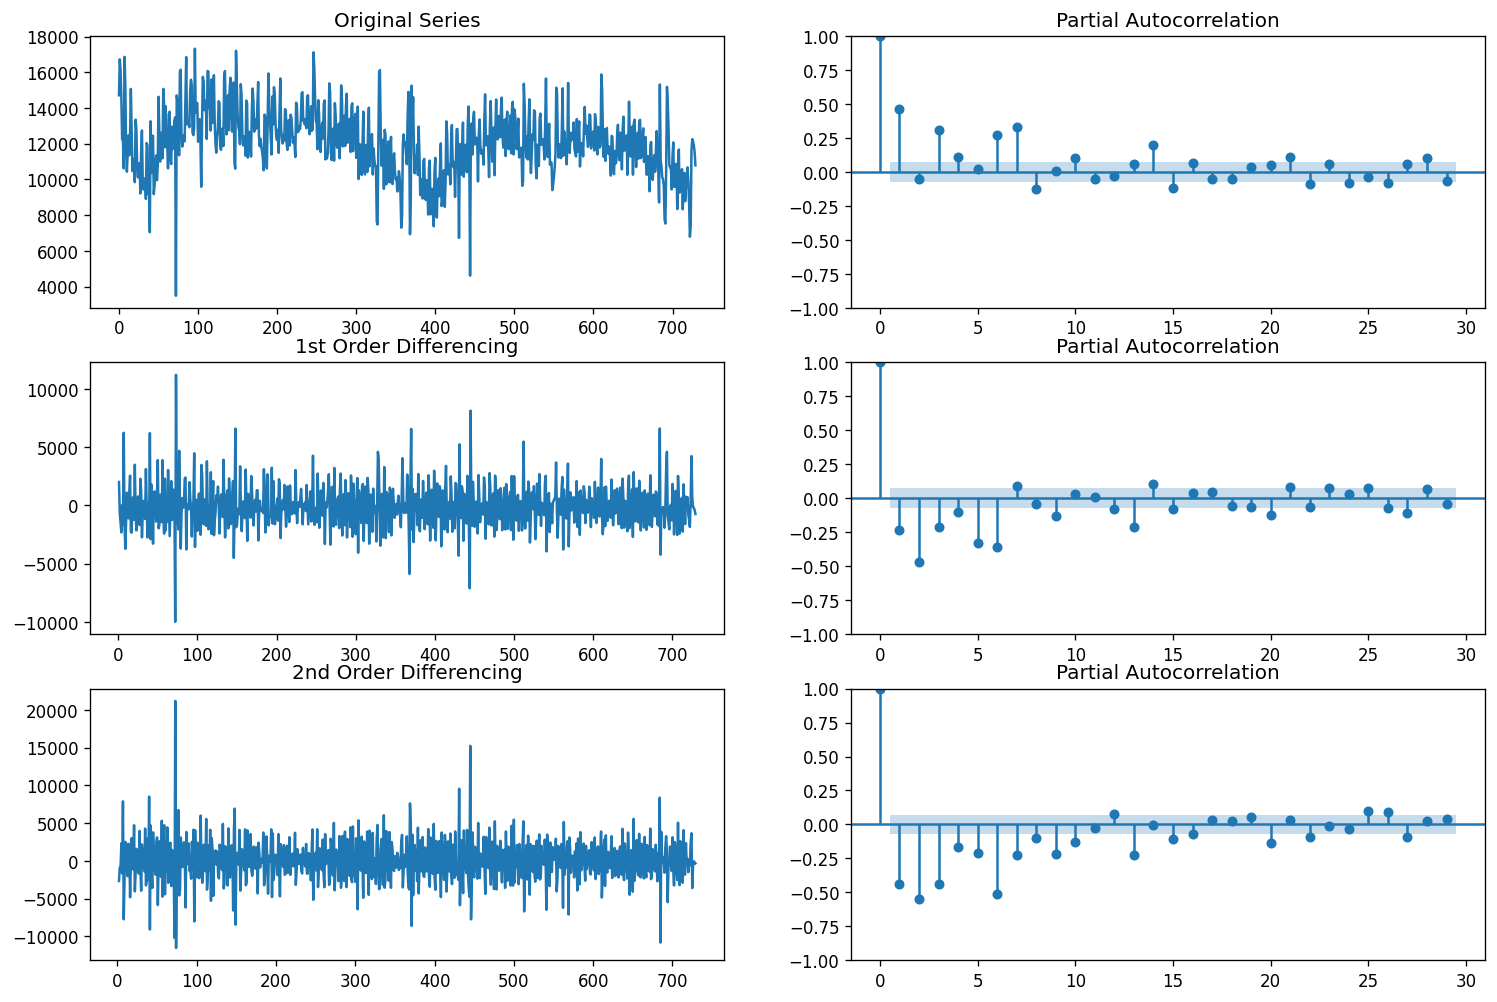

In [19]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(daily_taxi_pd.total); axes[0, 0].set_title('Original Series')
plot_pacf(daily_taxi_pd.total, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(daily_taxi_pd.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(daily_taxi_pd.total.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(daily_taxi_pd.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(daily_taxi_pd.total.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

One MA suggested - 0 lag is the far beyond the non-significance zone and this partial autocorrelation coefficient of first lag is much lower. Therefore, I think we might use the first order differencing.

In [20]:
# raw
series=daily_taxi_pd['total']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=daily_taxi_pd['total'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=daily_taxi_pd['total'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: -2.153742
  p-value: 0.223460

1st order differencing:
  ADF Statistic: -8.181998
  p-value: 0.000000

2nd order differencing:
  ADF Statistic: -12.229794
  p-value: 0.000000


From the result we can see, the data is stability after first order differencing.

### 4.2 build an ARIMA model using terms [P=0, D=1, Q=1], training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors.

In [21]:
P=0
D=1
Q=1

# fit model
N=700
series = daily_taxi_pd['total']

model = sm.tsa.ARIMA(series[:N], order=(P, D, Q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                  700
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6146.809
Date:                Fri, 15 Mar 2024   AIC                          12297.618
Time:                        17:15:46   BIC                          12306.718
Sample:                             0   HQIC                         12301.136
                                - 700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8936      0.016    -56.012      0.000      -0.925      -0.862
sigma2      2.514e+06   1.01e+05     24.986      0.000    2.32e+06    2.71e+06
Ljung-Box (L1) (Q):                  27.15   Jarque-

In [22]:
taxi_JFK2 = dd.from_pandas(taxi_JFK, npartitions=24)
hour_taxi = taxi_JFK2.groupby(['date','hour'])[locations].sum().reset_index()
hour_taxi['total'] = hour_taxi.drop(columns=['date','hour']).sum(axis=1)
hour_taxi.head()

,date,hour,1,2,3,4,5,6,7,8,...,257,258,259,260,261,262,263,264,265,total
0,2017-01-01,0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,3.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,27.0,527.0
1,2017-01-01,1,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,7.0,6.0,1.0,12.0,247.0
2,2017-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,105.0
3,2017-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,76.0
4,2017-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,46.0


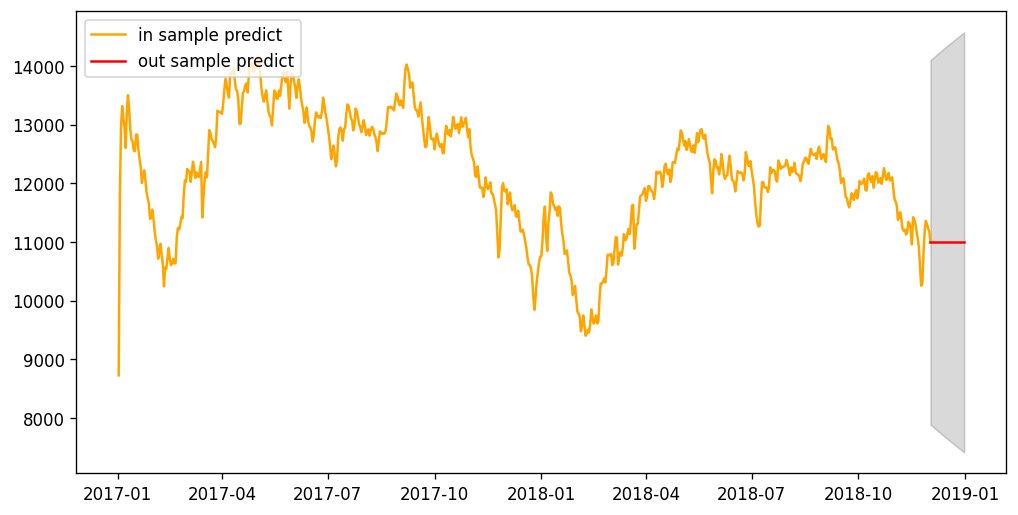

In [23]:
hour_taxi_pd=hour_taxi.compute()

# Forecast
fcast = model_fit.forecast(steps=len(series)-N) # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()
fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
#ax.plot(daily_taxi_pd.index[:N+1],series[:N+1],label='train_label') # train
#ax.plot(daily_taxi_pd.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(daily_taxi_pd['date'].iloc[1:N+1], model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
color='orange', label='in sample predict') # in-sample
ax.plot(daily_taxi_pd['date'].iloc[N:], fc_series, label='out sample predict', color='red') # forecast
ax.fill_between(daily_taxi_pd['date'].iloc[N:], lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')


# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct

### 5.1. standardization.
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [24]:
#your answer here

In [25]:
hour_2017 = hour_taxi_pd.query('date >= "2017-01-01" and date <= "2017-12-31"')
hour_2017 = hour_2017.set_index('date')
X_2017 = hour_2017.iloc[:, :-1]
X_2017.columns = X_2017.columns.astype(str)
X_2017 = X_2017.drop(columns=['hour'])
scalerDigits = preprocessing.StandardScaler().fit(X_2017)
hour_2017_S_array = scalerDigits.transform(X_2017)
hour_2017_S = pd.DataFrame(hour_2017_S_array, index=X_2017.index, columns=X_2017.columns)
hour_2017_S = hour_2017_S.iloc[:,:]

In [26]:
hour_2018 = hour_taxi_pd.query('date >= "2018-01-01" and date <= "2018-12-31"')
hour_2018 = hour_2018.set_index('date')
X_2018 = hour_2018.iloc[:, :-1]
X_2018.columns = X_2018.columns.astype(str)
X_2018 = X_2018.drop(columns=['hour'])
scalerDigits = preprocessing.StandardScaler().fit(X_2018)
hour_2018_S_array = scalerDigits.transform(X_2018)
hour_2018_S = pd.DataFrame(hour_2018_S_array, index=X_2018.index, columns=X_2018.columns)
hour_2018_S = hour_2018_S.iloc[:,:]

### 5.2. PCA

Train PCA on the standardized 2018 dataset. Set PCA components as 5, and gamma is None, use kernel ‘linear’. Report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data. (5 pts)

In [27]:
kpca = KernelPCA(kernel='linear', gamma=None, n_components=5, fit_inverse_transform=True)
kpca.fit(hour_2017_S)
hour_2018_pca = kpca.transform(hour_2018_S)

hour_2018_reconstructed = kpca.inverse_transform(hour_2018_pca)

In [28]:
mse = mean_squared_error(hour_2018_S, hour_2018_reconstructed)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.827321220821555


### 5.3 Add lag
add 12 lags of each component (pca_comps=5) (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [29]:
#your answer here

In [30]:
hour_2018_pca_df = pd.DataFrame(hour_2018_pca, index=hour_2018_S.index, columns=[f'component_{i}' for i in range(1, 6)])
hour_2018_pca_df.head()

,component_1,component_2,component_3,component_4,component_5
date,,,,,
2018-01-01,-2.720164,-4.312002,-0.554225,1.372271,0.879431
2018-01-01,-4.799956,-3.612092,-1.400683,-0.201888,-2.080059
2018-01-01,-8.787469,-0.853776,0.814226,-0.168481,-0.313817
2018-01-01,-8.658432,-1.091070,0.500887,0.579890,0.425699
2018-01-01,-7.905044,-1.693033,-0.752052,-0.783431,-0.666292


In [31]:
def add_lag_features(df, lag_range, components=5):
    lagged_df = pd.DataFrame(df, columns=[f'component_{i}' for i in range(1, components + 1)])

    for i in range(1, components + 1):
        for n in range(1, lag_range + 1):
            lagged_df[f'component_{i}_lag_{n}'] = lagged_df[f'component_{i}'].shift(n)

    lagged_df = lagged_df.dropna().reset_index(drop=True)
    print(f"Shape of the dataset with lag features: {lagged_df.shape}")
    return lagged_df


taxi_2018_lag = add_lag_features(hour_2018_pca_df, lag_range=12, components=5)

Shape of the dataset with lag features: (8748, 65)


## 6. RandomForest modeling

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%.


### 6.1 train test split
Please keep in mind that random train test split is not applicable in this case.

In [32]:
X = taxi_2018_lag.iloc[:, 5:]
y = taxi_2018_lag.iloc[:, :5]


size=int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]

siza_val=int(0.8*len(X_train))
X_train, X_val, y_train, y_val = X[:siza_val], X[siza_val:], y[:siza_val], y[siza_val:]



### 6.2 model performance measurement
Use the RandomForest model with the provided parameters (min_samples_split: 2, min_samples_leaf: 10, and n_estimators equal to 50.) to predict the compressed daily ridership. Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. report the taxi zone level R² value.




In [33]:
#your answer here
rf = RandomForestRegressor(min_samples_split=2, min_samples_leaf=10,n_estimators=50)
rf.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=10, n_estimators=50)

In [34]:
y_pre = rf.predict(X_test)
reconstructed_taxi = kpca.inverse_transform(y_pre)
reconstructed_taxi_S = scalerDigits.inverse_transform(reconstructed_taxi)

In [35]:
y_test_reconstructed_pca = kpca.inverse_transform(y_test)
y_test_reconstructed = scalerDigits.inverse_transform(y_test_reconstructed_pca)

In [36]:
r2_value = r2_score(y_test_reconstructed, reconstructed_taxi_S)
print("R²:", r2_value)

R²: 0.5986318254998836


In [37]:
R2 = []
for i in range(y_test_reconstructed.shape[1]):
    r2_zone = r2_score(y_test_reconstructed[:, i], reconstructed_taxi_S[:, i])
    R2.append(r2_zone)
print('The taxi zone level R² values are:', R2)

The taxi zone level R² values are: [0.6380876612020436, 0.21579848758923847, 0.5489573860647561, 0.7888569996436822, -0.008767763310038257, 0.34918977059197, 0.7630591341299627, 0.5268194431050743, 0.3766846407107687, 0.7764277511836934, 0.6463903328904488, 0.541783810454663, 0.8134805436756674, 0.7883880053558956, 0.6657100584819045, 0.6204030367799036, 0.7979726596248989, 0.4818154666920119, 0.4546186259850997, 0.5400412904330536, 0.4080764828399953, 0.5635032509504652, 0.36873540863584175, 0.8167195562473397, 0.8239508813600023, 0.21648264286885965, 0.7093154047583772, 0.6733102328456643, 0.5876394054602234, 0.5462567796502253, 0.6088827665538432, 0.48317384407436204, 0.7966425536584203, 0.6119490659146247, 0.4354026077815666, 0.7852081739344614, 0.799394849633931, 0.5761384171079622, 0.6005878830031448, 0.7945252299596874, 0.8066578042800497, 0.7892727097943952, 0.7976423326470334, 0.12265734385487193, 0.8173250403943382, 0.6991764058554752, 0.04111147348366928, 0.8095447339461886,